In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install tensorflow_addons

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 6.5 MB 55.3 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 41.6 MB/s 
     |████████████████████████████████| 895 kB 56.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [3]:
import json
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import keras
import keras.layers as layers
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from transformers import BertTokenizer, TFBertModel

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
df_train = pd.read_csv('/content/drive/My Drive/absa_sentihood/data/df_train.csv')
df_val = pd.read_csv('/content/drive/My Drive/absa_sentihood/data/df_val.csv')
df_test = pd.read_csv('/content/drive/My Drive/absa_sentihood/data/df_test.csv')

In [5]:
target_entities = ['LOCATION1', 'LOCATION2']
aspects = ['general','price','safety','transit-location']

Number of words

26.0

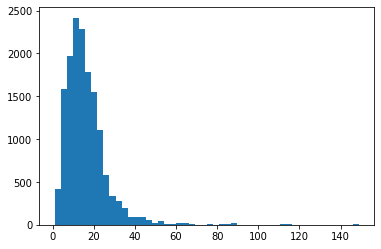

In [6]:
lens = [len(x.split()) for x in df_train["text"].tolist()]
plt.hist(lens, 50);
np.percentile(np.array(lens), 90)

### BERT config

In [7]:
MAX_SEQ_LEN = int(np.percentile(np.array(lens), 90))
BERT_NAME = 'bert-base-uncased'

In [8]:
def prepare_bert_input(sentences, seq_len, bert_name):
    '''
    Function to pre-process and tokenize texts.
    Returns input_ids and attention masks for BERT inputs
    '''
    tokenizer = BertTokenizer.from_pretrained(bert_name)
    encodings = tokenizer(sentences.tolist(), truncation=True, padding='max_length', max_length=seq_len, add_special_tokens=True, return_tensors='tf', return_token_type_ids = False, return_attention_mask = True)
    input = [np.array(encodings["input_ids"]), np.array(encodings["attention_mask"])]
    return input

def create_model():
    '''
    Function to return Model: BERT with classifier
    Multi-Task Learning
    '''
    bert = TFBertModel.from_pretrained(BERT_NAME)

    input_ids = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
    input_mask = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
    inputs = [input_ids, input_mask]
    
    bert_outputs = bert(inputs)[0]
    x = layers.GlobalAveragePooling1D()(bert_outputs)

    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.1)(x)

    output_general = layers.Dense(3, activation="softmax", name="output_general")(x)
    output_price = layers.Dense(3, activation="softmax", name="output_price")(x)
    output_safety = layers.Dense(3, activation="softmax", name="output_safety")(x)
    output_transit = layers.Dense(3, activation="softmax", name="output_transit")(x)

    model = keras.Model(inputs=inputs, outputs=[output_general, output_price, output_safety, output_transit])
    model.layers[2].trainable = True

    model.summary()
    plot_model(model)
    return model

def fine_tune(model, X_train, x_val, y_train, y_val, max_epochs=3, batch_size=64, lr=5e-05):
    '''
    Function to fit model
    '''
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.CategoricalCrossentropy()

    best_weights_file = "weights.h5"
    m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_loss', mode='min', verbose=2, save_weights_only=True, save_best_only=True)

    model.compile(loss={"output_general":loss, "output_price":loss, "output_safety":loss, "output_transit":loss}, 
                  optimizer=opt,
                  metrics=[tfa.metrics.F1Score(average='macro',num_classes=3),'acc'])
    
    model.fit(X_train, {"output_general":y_train[:, 0], "output_price":y_train[:, 1], "output_safety":y_train[:, 2], "output_transit":y_train[:, 3]},
              validation_data =(x_val, {"output_general":y_val[:, 0], "output_price":y_val[:, 1], "output_safety":y_val[:, 2], "output_transit":y_val[:, 3]}),
              epochs=max_epochs, batch_size=batch_size, callbacks=[m_ckpt], verbose=2)

def load_model(lr=5e-05):
    model = create_model()
    loss = keras.losses.CategoricalCrossentropy()
    best_weights_file = "weights.h5"
    model.load_weights(best_weights_file)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss={"output_general":loss, "output_price":loss, "output_safety":loss, "output_transit":loss}, 
                  optimizer=opt,
                  metrics=[tfa.metrics.F1Score(average='macro',num_classes=3),'acc'])
    return model

## Modeling

For training on single-location and double-location tasks


In [ ]:
# df_train_L1   = df_train[~df_train["text"].str.contains("LOCATION2")]
# df_train_L1L2 = df_train[df_train["text"].str.contains("LOCATION2")]

# df_val_L1   = df_val[~df_val["text"].str.contains("LOCATION2")]
# df_val_L1L2 = df_val[df_val["text"].str.contains("LOCATION2")]

# df_test_L1   = df_test[~df_test["text"].str.contains("LOCATION2")]
# df_test_L1L2 = df_test[df_test["text"].str.contains("LOCATION2")]

For training on Location-1 and Location-2 separately

In [9]:
df_train_L1 = df_train[df_train["target_entity"]=="LOCATION1"]
df_train_L2 = df_train[df_train["target_entity"]=="LOCATION2"]

df_val_L1 = df_val[df_val["target_entity"]=="LOCATION1"]
df_val_L2 = df_val[df_val["target_entity"]=="LOCATION2"]

df_test_L1 = df_test[df_test["target_entity"]=="LOCATION1"]
df_test_L2 = df_test[df_test["target_entity"]=="LOCATION2"]

In [10]:
def get_text_labels(df):
    '''
    Given a dataframe, return three lists containing corresponding ids, texts and labels.
    labels are dicts for each text, having keys as aspect name and value as sentiment name
    '''
    texts = []
    ids = []
    labels = []

    for id, df in df.groupby("id"):
        # if not set(df["sentiment"])=={"None"}:   # to skip if all aspect sentiments are None
        texts.append(df["text"].tolist()[0])
        label = dict()
        for aspect in aspects:
            label[aspect] = df[df["aspect"]==aspect]["sentiment"].tolist()[0]
        labels.append(label)
        ids.append(id)
            
    return np.asarray(texts), np.asarray(ids), labels

One Hot Encode labels

In [11]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit([
         ["Negative"], 
         ["None"], 
         ["Positive"]
         ])

OneHotEncoder()

### Location 1

#### Prepare Data
1. (train/val/test)_texts: np array containing texts. shape (freq, )
2. (train/val/test)_labels: np array containing labels for each text. shape (freq, 4, 3) where 4 is number of aspects and 3 is number of classes.

In [12]:
train_texts, train_ids, train_labels = get_text_labels(df_train_L1)

# Example
print(train_texts[10])
print(train_labels[10])

labels = []
for label_dict in train_labels:
    ohe_rep = []
    for aspect,sentiment in label_dict.items():
        ohe_rep.append(enc.transform([[sentiment]]).toarray().tolist()[0])
    labels.append(ohe_rep)
train_labels = np.array(labels)

# Example
print(train_labels[10])

train_texts.shape

steer clear of LOCATION1
{'general': 'Negative', 'price': 'None', 'safety': 'None', 'transit-location': 'None'}
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


(2977,)

In [13]:
val_texts, val_ids, val_labels = get_text_labels(df_val_L1)
labels = []
for label_dict in val_labels:
    ohe_rep = []
    for aspect,sentiment in label_dict.items():
        ohe_rep.append(enc.transform([[sentiment]]).toarray().tolist()[0])
    labels.append(ohe_rep)
val_labels = np.array(labels)
val_texts.shape

(747,)

In [14]:
test_texts, test_ids, test_labels = get_text_labels(df_test_L1)
labels = []
for label_dict in test_labels:
    ohe_rep = []
    for aspect,sentiment in label_dict.items():
        ohe_rep.append(enc.transform([[sentiment]]).toarray().tolist()[0])
    labels.append(ohe_rep)
test_labels = np.array(labels)
test_texts.shape

(1491,)

In [15]:
del labels

#### Training: Classification

In [17]:
X_train = prepare_bert_input(train_texts, MAX_SEQ_LEN, BERT_NAME)
X_val = prepare_bert_input(val_texts, MAX_SEQ_LEN, BERT_NAME)
X_test = prepare_bert_input(test_texts, MAX_SEQ_LEN, BERT_NAME)

y_train = train_labels
y_val = val_labels
y_test = test_labels

model_1 = create_model()

fine_tune(model_1, X_train, X_val, y_train, y_val, max_epochs=3, batch_size=64)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 26)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 26)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 26,                                          

In [18]:
model_1_metric_vals = model_1.evaluate(X_test, {"output_general":y_test[:, 0], "output_price":y_test[:, 1], "output_safety":y_test[:, 2], "output_transit":y_test[:, 3]}, batch_size=32)

47/47 [==============================] - 123s 3s/step - loss: 1.0235 - output_general_loss: 0.5008 - output_price_loss: 0.1619 - output_safety_loss: 0.1322 - output_transit_loss: 0.2286 - output_general_f1_score: 0.7385 - output_general_acc: 0.8384 - output_price_f1_score: 0.8202 - output_price_acc: 0.9497 - output_safety_f1_score: 0.8236 - output_safety_acc: 0.9651 - output_transit_f1_score: 0.6037 - output_transit_acc: 0.9188


In [19]:
model_1_perf = {k:v for k,v in zip(model_1.metrics_names, model_1_metric_vals)}
model_1_perf

{'loss': 1.0235340595245361,
 'output_general_acc': 0.838363528251648,
 'output_general_f1_score': 0.738513708114624,
 'output_general_loss': 0.5007959008216858,
 'output_price_acc': 0.9496982097625732,
 'output_price_f1_score': 0.8201643824577332,
 'output_price_loss': 0.16193678975105286,
 'output_safety_acc': 0.9651240706443787,
 'output_safety_f1_score': 0.8235567212104797,
 'output_safety_loss': 0.13218432664871216,
 'output_transit_acc': 0.9188464283943176,
 'output_transit_f1_score': 0.6037495732307434,
 'output_transit_loss': 0.22861720621585846}

#### Predict on Test

In [20]:
# model_1 = load_model()
predictions = model_1.predict(X_test)
predictions = np.array(predictions)
predictions = np.array([predictions[:,i] for i in range(predictions.shape[1])])

In [21]:
test_preds = []
for i in range(predictions.shape[0]):
    preds = np.argmax(predictions[i], axis=1)
    ohe_preds = np.zeros((predictions[i].shape[0], 3))
    ohe_preds[np.arange(ohe_preds.shape[0]), preds] = 1
    test_preds.append(ohe_preds)
test_preds = np.array(test_preds)

In [22]:
output_json_L1 = []

for i in range(test_ids.shape[0]):
    sample = {}
    sample["id"] = int(test_ids[i])
    sample["text"] = test_texts[i]
    opinions = []
    true_labels = enc.inverse_transform(test_labels[i])
    for j,aspect in enumerate(aspects):
        if true_labels[j][0]!='None':
            opinions.append({'aspect':aspect,
                             'sentiment':true_labels[j][0],
                             'target_entity':'LOCATION1'})
    model_pred = []
    pred_labels = enc.inverse_transform(test_preds[i])
    for j,aspect in enumerate(aspects):
        if pred_labels[j][0]!='None':
            model_pred.append({'aspect':aspect,
                             'sentiment':pred_labels[j][0],
                             'target_entity':'LOCATION1'})
    sample["opinions"] = opinions
    sample["model_pred"] = model_pred

    output_json_L1.append(sample)

In [23]:
# with open("output_json_L1.json", "w") as f:
#     json.dump(output_json_L1, f)

In [24]:
output_json_L1[52]

{'id': 52,
 'model_pred': [{'aspect': 'general',
   'sentiment': 'Negative',
   'target_entity': 'LOCATION1'}],
 'opinions': [{'aspect': 'general',
   'sentiment': 'Negative',
   'target_entity': 'LOCATION1'}],
 'text': 'LOCATION1  which is a craphole keep clear'}

### Location 2

#### Prepare Data
1. (train/val/test)_texts: np array containing texts. shape (freq, )
2. (train/val/test)_labels: np array containing labels for each text. shape (freq, 4, 3) where 4 is number of aspects and 3 is number of classes.

In [25]:
train_texts_2, train_ids_2, train_labels_2 = get_text_labels(df_train_L2)

# Example
print(train_texts_2[10])
print(train_labels_2[10])

labels = []
for label_dict in train_labels_2:
    ohe_rep = []
    for aspect,sentiment in label_dict.items():
        ohe_rep.append(enc.transform([[sentiment]]).toarray().tolist()[0])
    labels.append(ohe_rep)
train_labels_2 = np.array(labels)

# Example
print(train_labels_2[10])

train_texts_2.shape

I've never been to LOCATION2, so don't know about that one  LOCATION1
{'general': 'None', 'price': 'None', 'safety': 'None', 'transit-location': 'None'}
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


(775,)

In [26]:
val_texts_2, val_ids_2, val_labels_2 = get_text_labels(df_val_L2)
labels = []
for label_dict in val_labels_2:
    ohe_rep = []
    for aspect,sentiment in label_dict.items():
        ohe_rep.append(enc.transform([[sentiment]]).toarray().tolist()[0])
    labels.append(ohe_rep)
val_labels_2 = np.array(labels)
val_texts_2.shape

(190,)

In [27]:
test_texts_2, test_ids_2, test_labels_2 = get_text_labels(df_test_L2)
labels = []
for label_dict in test_labels_2:
    ohe_rep = []
    for aspect,sentiment in label_dict.items():
        ohe_rep.append(enc.transform([[sentiment]]).toarray().tolist()[0])
    labels.append(ohe_rep)
test_labels_2 = np.array(labels)
test_texts_2.shape

(388,)

In [28]:
del labels

#### Training: Classification

In [29]:
######### BERT SENTIMENT CLASSIFICATION #########

X_train_2 = prepare_bert_input(train_texts_2, MAX_SEQ_LEN, BERT_NAME)
X_val_2 = prepare_bert_input(val_texts_2, MAX_SEQ_LEN, BERT_NAME)
X_test_2 = prepare_bert_input(test_texts_2, MAX_SEQ_LEN, BERT_NAME)

y_train_2 = train_labels_2
y_val_2 = val_labels_2
y_test_2 = test_labels_2

model_2 = create_model()

fine_tune(model_2, X_train_2, X_val_2, y_train_2, y_val_2, max_epochs=3, batch_size=32)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 26)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 26)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 26,                                          

In [30]:
model_2_metric_vals = model_2.evaluate(X_test_2, {"output_general":y_test_2[:, 0], "output_price":y_test_2[:, 1], "output_safety":y_test_2[:, 2], "output_transit":y_test_2[:, 3]}, batch_size=32)

13/13 [==============================] - 32s 2s/step - loss: 1.2860 - output_general_loss: 0.5442 - output_price_loss: 0.2215 - output_safety_loss: 0.2190 - output_transit_loss: 0.3012 - output_general_f1_score: 0.6102 - output_general_acc: 0.8119 - output_price_f1_score: 0.6802 - output_price_acc: 0.9098 - output_safety_f1_score: 0.5904 - output_safety_acc: 0.9381 - output_transit_f1_score: 0.4803 - output_transit_acc: 0.9098


In [31]:
model_2_perf = {k:v for k,v in zip(model_2.metrics_names, model_2_metric_vals)}
model_2_perf

{'loss': 1.2859824895858765,
 'output_general_acc': 0.811855673789978,
 'output_general_f1_score': 0.6101882457733154,
 'output_general_loss': 0.5442336797714233,
 'output_price_acc': 0.9097937941551208,
 'output_price_f1_score': 0.680194079875946,
 'output_price_loss': 0.22153006494045258,
 'output_safety_acc': 0.938144326210022,
 'output_safety_f1_score': 0.5904240608215332,
 'output_safety_loss': 0.21901924908161163,
 'output_transit_acc': 0.9097937941551208,
 'output_transit_f1_score': 0.4802957773208618,
 'output_transit_loss': 0.30119946599006653}

#### Predict on Test

In [32]:
# model_2 = load_model()
predictions_2 = model_2.predict(X_test_2)
predictions_2 = np.array(predictions_2)
predictions_2 = np.array([predictions_2[:,i] for i in range(predictions_2.shape[1])])

In [33]:
test_preds_2 = []
for i in range(predictions_2.shape[0]):
    preds = np.argmax(predictions_2[i], axis=1)
    ohe_preds = np.zeros((predictions_2[i].shape[0], 3))
    ohe_preds[np.arange(ohe_preds.shape[0]), preds] = 1
    test_preds_2.append(ohe_preds)
test_preds_2 = np.array(test_preds_2)

## Create pred.jsonl

In [34]:
for i in range(test_ids_2.shape[0]):
    index = next((index for (index, d) in enumerate(output_json_L1) if d["id"] == int(test_ids_2[i])), None)
    if index:
        opinions = []
        true_labels = enc.inverse_transform(test_labels_2[i])
        for j,aspect in enumerate(aspects):
            if true_labels[j][0]!='None':
                opinions.append({'aspect':aspect,
                                'sentiment':true_labels[j][0],
                                'target_entity':'LOCATION2'})
        model_pred = []
        pred_labels = enc.inverse_transform(test_preds_2[i])
        for j,aspect in enumerate(aspects):
            if pred_labels[j][0]!='None':
                model_pred.append({'aspect':aspect,
                                'sentiment':pred_labels[j][0],
                                'target_entity':'LOCATION2'})
        output_json_L1[index]["opinions"] += opinions
        output_json_L1[index]["model_pred"] += model_pred
    else:
        sample = {}
        sample["id"] = int(test_ids_2[i])
        sample["text"] = test_texts_2[i]
        opinions = []
        true_labels = enc.inverse_transform(test_labels_2[i])
        for j,aspect in enumerate(aspects):
            if true_labels[j][0]!='None':
                opinions.append({'aspect':aspect,
                                'sentiment':true_labels[j][0],
                                'target_entity':'LOCATION2'})
        model_pred = []
        pred_labels = enc.inverse_transform(test_preds_2[i])
        for j,aspect in enumerate(aspects):
            if pred_labels[j][0]!='None':
                model_pred.append({'aspect':aspect,
                                'sentiment':pred_labels[j][0],
                                'target_entity':'LOCATION2'})
        sample["opinions"] = opinions
        sample["model_pred"] = model_pred

        output_json_L1.append(sample)

In [35]:
output_json_L1[-50]

{'id': 1449,
 'model_pred': [{'aspect': 'price',
   'sentiment': 'Negative',
   'target_entity': 'LOCATION1'},
  {'aspect': 'price', 'sentiment': 'Negative', 'target_entity': 'LOCATION2'}],
 'opinions': [{'aspect': 'price',
   'sentiment': 'Negative',
   'target_entity': 'LOCATION1'},
  {'aspect': 'price', 'sentiment': 'Negative', 'target_entity': 'LOCATION2'}],
 'text': "If you're up to spend a lot, theres a lot of posh places across LOCATION2 and LOCATION1"}

In [36]:
with open("/content/drive/My Drive/absa_sentihood/preds.jsonl", "w") as f:
    json.dump(output_json_L1, f, indent = 3)

# Cconfusion Matrix

In [37]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Refered https://stackoverflow.com/questions/58766561/scikit-learn-sklearn-confusion-matrix-plot-for-more-than-3-classes 
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    # plt.xlim(-0.5, len(np.unique(y))-0.5)
    # plt.ylim(len(np.unique(y))-0.5, -0.5)
    return ax

In [39]:
from sklearn.metrics import confusion_matrix

Overall performance for each aspect for Loc-1 and Loc-2 combined 


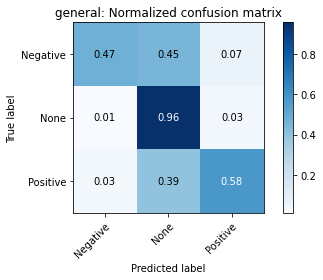

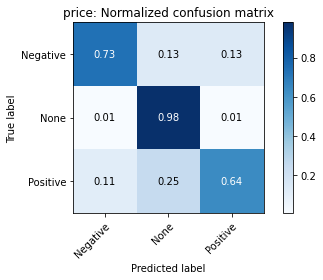

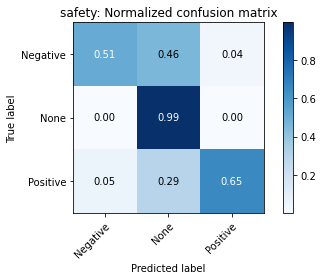

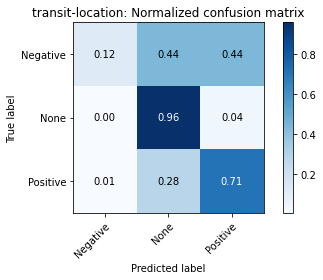

In [52]:
for i,aspect in enumerate(aspects):
  y_true = enc.inverse_transform(np.concatenate([test_labels[:, i], test_labels_2[:, i]]))
  y_pred = enc.inverse_transform(np.concatenate([test_preds[:, i], test_preds_2[:, i]]))

  plot_confusion_matrix(y_true, y_pred, classes=np.array(['Negative','None','Positive']), normalize=True, title=aspect+': Normalized confusion matrix')
  plt.show()